In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import datetime

# custom
import utils.loss as loss_utils
from utils.data import ClimatehackDataset, CustomDataset, OSGBDataset

In [2]:
from fastai.vision.all import *

## Data

In [3]:
ds = OSGBDataset("data/test.npz")

In [5]:
x, y = ds[0]

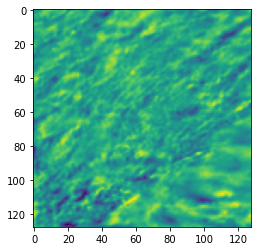

In [16]:
plt.imshow(x[11] -  y[0])

In [3]:
# SATELLITE_ZARR_PATH = "gs://public-datasets-eumetsat-solar-forecasting/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr"
SATELLITE_ZARR_PATH = 'data/eumetsat_seviri_hrv_uk.zarr/'

dataset = xr.open_dataset(
    SATELLITE_ZARR_PATH,
    engine="zarr",
    chunks="auto",  # Load the data as a Dask array
)

print(dataset)

<xarray.Dataset>
Dimensions:  (time: 173624, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(22, 891, 1843), meta=np.ndarray>


In [4]:
BATCH_SIZE = 32
train_ds = climatehack_dataset.ClimatehackDataset(dataset, random_state=7)
valid_ds = climatehack_dataset.ClimatehackDataset(dataset, random_state=3)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE)

## Inference

In [5]:
FORECAST = 24
criterion = loss_utils.MS_SSIMLoss(channels=FORECAST)

In [6]:
model = create_unet_model(
    arch=models.resnet50, img_size=(128, 128), n_out=24, pretrained=True, n_in=12, self_attention=True, 
)

In [8]:
model.load_state_dict(torch.load('checkpoints/dynamic_unet.pth'))

<All keys matched successfully>

In [14]:
sample = train_ds[0]
x, y = torch.tensor(sample[0]), torch.tensor(sample[1])